# Motor Mode: No-Load Startup + Nominal Load Step

This notebook runs an induction motor in motor mode:
- startup at no-load,
- load step at **t = 2.0 s** to ** nominal torque**.

Focus: detailed stator current analysis for phases **A/B** and resultant magnitude **|I1|**,
including startup peak, step transient, and post-step steady-state values.


In [53]:
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MaxNLocator

cwd = Path.cwd().resolve()
project_root = cwd.parent if cwd.name.lower() == "notebooks" else cwd
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"

output_dir = project_root / "output" / "notebooks_currents"
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Figures will be saved to: {output_dir}")


def robust_level_stats(x: np.ndarray) -> dict:
    x = np.asarray(x)
    return {
        "median": float(np.median(x)),
        "p05": float(np.percentile(x, 5)),
        "p95": float(np.percentile(x, 95)),
        "p99": float(np.percentile(x, 99)),
        "min": float(np.min(x)),
        "max": float(np.max(x)),
        "peak_abs": float(np.max(np.abs(x))),
    }


def cycle_rms_stats(
    t: np.ndarray,
    x: np.ndarray,
    freq_hz: float,
    n_cycles: int = 8,
) -> dict:
    t = np.asarray(t)
    x = np.asarray(x)
    if t.size < 16:
        raise ValueError("Not enough samples for cycle statistics")

    period = 1.0 / float(freq_hz)
    t_start = max(float(t[0]), float(t[-1] - n_cycles * period))
    mask = t >= t_start

    tw = t[mask]
    xw = x[mask]
    if tw.size < 16:
        tw = t
        xw = x

    dt = float(np.median(np.diff(tw)))
    samples_per_cycle = max(8, int(round(period / dt)))
    n_full_cycles = max(1, xw.size // samples_per_cycle)

    x_use = xw[-n_full_cycles * samples_per_cycle :]
    cycles = x_use.reshape(n_full_cycles, samples_per_cycle)

    rms_cycles = np.sqrt(np.mean(cycles**2, axis=1))
    peak_abs_cycles = np.max(np.abs(cycles), axis=1)

    return {
        "rms_median": float(np.median(rms_cycles)),
        "rms_p05": float(np.percentile(rms_cycles, 5)),
        "rms_p95": float(np.percentile(rms_cycles, 95)),
        "rms_min": float(np.min(rms_cycles)),
        "rms_max": float(np.max(rms_cycles)),
        "peak_abs_median": float(np.median(peak_abs_cycles)),
        "peak_abs_max": float(np.max(peak_abs_cycles)),
        "n_cycles": int(n_full_cycles),
    }


def y_limits(y: np.ndarray, pad: float = 0.08) -> tuple[float, float]:
    y = np.asarray(y)
    ymin = float(np.min(y))
    ymax = float(np.max(y))
    span = max(ymax - ymin, 1e-9)
    return ymin - pad * span, ymax + pad * span


def style_axis(
    ax,
    title: str,
    ylabel: str = "Current, A",
    xbins: int = 18,
    ybins: int = 14,
    x_minor: int = 5,
    y_minor: int = 5,
):
    ax.set_title(title, fontsize=12, weight="bold")
    ax.set_xlabel("Time, s")
    ax.set_ylabel(ylabel)
    ax.ticklabel_format(style="plain", axis="both")
    ax.tick_params(axis="both", labelsize=9)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=xbins, min_n_ticks=8))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=ybins, min_n_ticks=8))
    ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor))
    ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor))

    ax.grid(True, which="major", linewidth=0.9, alpha=0.85, color="#a8a8a8")
    ax.grid(True, which="minor", linestyle=":", linewidth=0.65, alpha=0.75, color="#bdbdbd")


def mark_point_with_projection(
    ax,
    x: float,
    y: float,
    label: str,
    color: str,
    text_offset: tuple[int, int] = (10, 10),
):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    dx = max(xmax - xmin, 1e-12)
    dy = max(ymax - ymin, 1e-12)

    ax.scatter([x], [y], color=color, s=40, zorder=8)
    ax.vlines(x, ymin, y, colors=color, linestyles="--", linewidth=1.0, alpha=0.95)
    ax.hlines(y, xmin, x, colors=color, linestyles="--", linewidth=1.0, alpha=0.95)

    # Keep projection labels inside axes to avoid layout drift.
    ax.text(
        x,
        ymin + 0.03 * dy,
        f"t={x:.4f} s",
        rotation=90,
        va="bottom",
        ha="center",
        color=color,
        fontsize=8,
        clip_on=True,
        bbox=dict(facecolor="white", edgecolor=color, alpha=0.85, pad=1.0),
    )
    ax.text(
        xmin + 0.01 * dx,
        y,
        f"I={y:.1f} A",
        va="center",
        ha="left",
        color=color,
        fontsize=8,
        clip_on=True,
        bbox=dict(facecolor="white", edgecolor=color, alpha=0.85, pad=1.0),
    )

    ax.annotate(
        f"{label}\n(t={x:.4f} s, I={y:.1f} A)",
        xy=(x, y),
        xytext=text_offset,
        textcoords="offset points",
        fontsize=8,
        color=color,
        bbox=dict(facecolor="white", edgecolor=color, alpha=0.9, boxstyle="round,pad=0.25"),
        arrowprops=dict(arrowstyle="->", color=color, lw=1.0),
    )

from core.parameters import MachineParameters
from solvers import ScipySolver, SolverConfig
from scenarios import MotorStepLoadScenario
from simulation import SimulationBuilder


Figures will be saved to: C:\Users\Пользователь\PycharmProjects\asynchronousMachine\output\notebooks_currents


In [54]:
params = MachineParameters()

t_step = 2.0
Mc_75 = 1 * params.M_nom

solver_cfg = SolverConfig(
    dt_out=5e-5,
    max_step=5e-5,
    rtol=1e-6,
    atol=1e-8,
)

scenario = MotorStepLoadScenario(
    t_end=4.0,
    t_step=t_step,
    Mc_load=Mc_75,
    Mc_idle=0.0,
)

res = (
    SimulationBuilder(params)
    .solver(ScipySolver("RK45", config=solver_cfg))
    .scenario(scenario)
    .run()
)

print(f"Nominal torque M_nom = {params.M_nom:.2f} Nm")
print(f"Step load       = {Mc_75:.2f} Nm")




  ПУСК АД НА ХХ + НАБРОС НАГРУЗКИ
  Модель: LinearInductionMachine
  Солвер: SciPy solve_ivp (RK45), rtol=1e-06, atol=1e-08, max_step=5e-05
  Источник: 3-фазная синусоида: Um=465.4 В, f=50.0 Гц, phi_0=0.0degrees
  Нагрузка: Ступенька: 0 Нм → 1096 Нм в t=2.00 с
  t = [0.00, 4.00] с


  Решение получено. Точек: 80000

  Сценарий: ПУСК АД НА ХХ + НАБРОС НАГРУЗКИ
  Солвер: SciPy solve_ivp (RK45), rtol=1e-06, atol=1e-08, max_step=5e-05
  Точек: 80000, t = [0.000 .. 4.000] с
  Скорость (уст.): 1481.8 об/мин
  Скольжение (уст.): 0.01213
  Mэм (уст.): 1096.1 Нм
  |I1| (уст.): 280.7 А
  I1A (уст., фазн., RMS): 198.5 А
  I1B (уст., фазн., RMS): 198.5 А
  P_элек (уст.): 175.6 кВт
  P_мех (уст.): 170.1 кВт


Nominal torque M_nom = 1096.14 Nm
Step load       = 1096.14 Nm


In [55]:
t = res.t
iA = res.i1A
iB = res.i1B
I1 = res.I1_mod

startup_end = 0.35
step_half_window = 0.25
steady_window = 0.40
steady_zoom_len = 0.12

mask_start = t <= startup_end
mask_step = (t >= (t_step - step_half_window)) & (t <= (t_step + step_half_window))
mask_pre = (t >= (t_step - 0.40)) & (t < (t_step - 0.05))
mask_post = t >= (t[-1] - steady_window)
mask_steady_zoom = t >= (t[-1] - steady_zoom_len)

t_start = t[mask_start]
iA_start = iA[mask_start]
iB_start = iB[mask_start]
I1_start = I1[mask_start]

t_step_zoom = t[mask_step]
iA_step = iA[mask_step]
iB_step = iB[mask_step]
I1_step = I1[mask_step]

t_pre = t[mask_pre]
iA_pre = iA[mask_pre]
iB_pre = iB[mask_pre]
I1_pre = I1[mask_pre]

t_post = t[mask_post]
iA_post = iA[mask_post]
iB_post = iB[mask_post]
I1_post = I1[mask_post]

t_steady_zoom = t[mask_steady_zoom]
iA_steady_zoom = iA[mask_steady_zoom]
iB_steady_zoom = iB[mask_steady_zoom]
I1_steady_zoom = I1[mask_steady_zoom]

# Startup peaks (A/B)
peak_idx_A = int(np.argmax(np.abs(iA_start)))
peak_idx_B = int(np.argmax(np.abs(iB_start)))
t_peak_A = float(t_start[peak_idx_A])
t_peak_B = float(t_start[peak_idx_B])
i_peak_A = float(iA_start[peak_idx_A])
i_peak_B = float(iB_start[peak_idx_B])

# Step transient peaks (A/B)
step_peak_idx_A = int(np.argmax(np.abs(iA_step)))
step_peak_idx_B = int(np.argmax(np.abs(iB_step)))
t_step_peak_A = float(t_step_zoom[step_peak_idx_A])
t_step_peak_B = float(t_step_zoom[step_peak_idx_B])
i_step_peak_A = float(iA_step[step_peak_idx_A])
i_step_peak_B = float(iB_step[step_peak_idx_B])

# Post-step steady peaks (A/B)
post_peak_idx_A = int(np.argmax(np.abs(iA_post)))
post_peak_idx_B = int(np.argmax(np.abs(iB_post)))
t_post_peak_A = float(t_post[post_peak_idx_A])
t_post_peak_B = float(t_post[post_peak_idx_B])
i_post_peak_A = float(iA_post[post_peak_idx_A])
i_post_peak_B = float(iB_post[post_peak_idx_B])

# Robust regime statistics
iA_pre_stats = cycle_rms_stats(t_pre, iA_pre, freq_hz=params.fn, n_cycles=8)
iB_pre_stats = cycle_rms_stats(t_pre, iB_pre, freq_hz=params.fn, n_cycles=8)
iA_post_stats = cycle_rms_stats(t_post, iA_post, freq_hz=params.fn, n_cycles=8)
iB_post_stats = cycle_rms_stats(t_post, iB_post, freq_hz=params.fn, n_cycles=8)

I1_pre_stats = robust_level_stats(I1_pre)
I1_post_stats = robust_level_stats(I1_post)
I1_start_stats = robust_level_stats(I1_start)
I1_step_stats = robust_level_stats(I1_step)

I1_peak_start = I1_start_stats["max"]
I1_peak_start_idx = int(np.argmax(I1_start))
t_I1_peak_start = float(t_start[I1_peak_start_idx])

I1_step_peak = I1_step_stats["max"]
I1_step_peak_idx = int(np.argmax(I1_step))
t_I1_step_peak = float(t_step_zoom[I1_step_peak_idx])

I1_pre_median = I1_pre_stats["median"]
I1_pre_p95 = I1_pre_stats["p95"]
I1_post_median = I1_post_stats["median"]
I1_post_p95 = I1_post_stats["p95"]

I1_post_ref_time = float(t[-1] - 0.06)
I1_pre_ref_time = float(t_step - 0.20)

I1_post_overshoot_pct = 100.0 * (I1_step_peak - I1_post_median) / I1_post_median

print(f"Startup peak |i1A|: {abs(i_peak_A):.2f} A at t={t_peak_A:.4f} s")
print(f"Startup peak |i1B|: {abs(i_peak_B):.2f} A at t={t_peak_B:.4f} s")
print(f"Startup peak |I1|:  {I1_peak_start:.2f} A at t={t_I1_peak_start:.4f} s")
print(f"Step peak |I1|:     {I1_step_peak:.2f} A at t={t_I1_step_peak:.4f} s")
print(f"Step overshoot vs post-steady median: {I1_post_overshoot_pct:.2f} %")
print(f"Pre-step i1A RMS (cycle median):  {iA_pre_stats['rms_median']:.2f} A [P05..P95: {iA_pre_stats['rms_p05']:.2f}..{iA_pre_stats['rms_p95']:.2f}]")
print(f"Pre-step i1B RMS (cycle median):  {iB_pre_stats['rms_median']:.2f} A [P05..P95: {iB_pre_stats['rms_p05']:.2f}..{iB_pre_stats['rms_p95']:.2f}]")
print(f"Post-step i1A RMS (cycle median): {iA_post_stats['rms_median']:.2f} A [P05..P95: {iA_post_stats['rms_p05']:.2f}..{iA_post_stats['rms_p95']:.2f}]")
print(f"Post-step i1B RMS (cycle median): {iB_post_stats['rms_median']:.2f} A [P05..P95: {iB_post_stats['rms_p05']:.2f}..{iB_post_stats['rms_p95']:.2f}]")
print(f"Pre-step |I1| median/P95:  {I1_pre_median:.2f} / {I1_pre_p95:.2f} A")
print(f"Post-step |I1| median/P95: {I1_post_median:.2f} / {I1_post_p95:.2f} A")


Startup peak |i1A|: 2371.25 A at t=0.0092 s
Startup peak |i1B|: 1848.15 A at t=0.0061 s
Startup peak |I1|:  2371.26 A at t=0.0092 s
Step peak |I1|:     426.89 A at t=2.0499 s
Step overshoot vs post-steady median: 52.07 %
Pre-step i1A RMS (cycle median):  56.76 A [P05..P95: 56.76..56.76]
Pre-step i1B RMS (cycle median):  56.76 A [P05..P95: 56.76..56.76]
Post-step i1A RMS (cycle median): 198.50 A [P05..P95: 198.50..198.50]
Post-step i1B RMS (cycle median): 198.50 A [P05..P95: 198.50..198.50]
Pre-step |I1| median/P95:  80.27 / 80.28 A
Post-step |I1| median/P95: 280.72 / 280.72 A


Saved: C:\Users\Пользователь\PycharmProjects\asynchronousMachine\output\notebooks_currents\02_motor_step_phase_AB_detailed.png


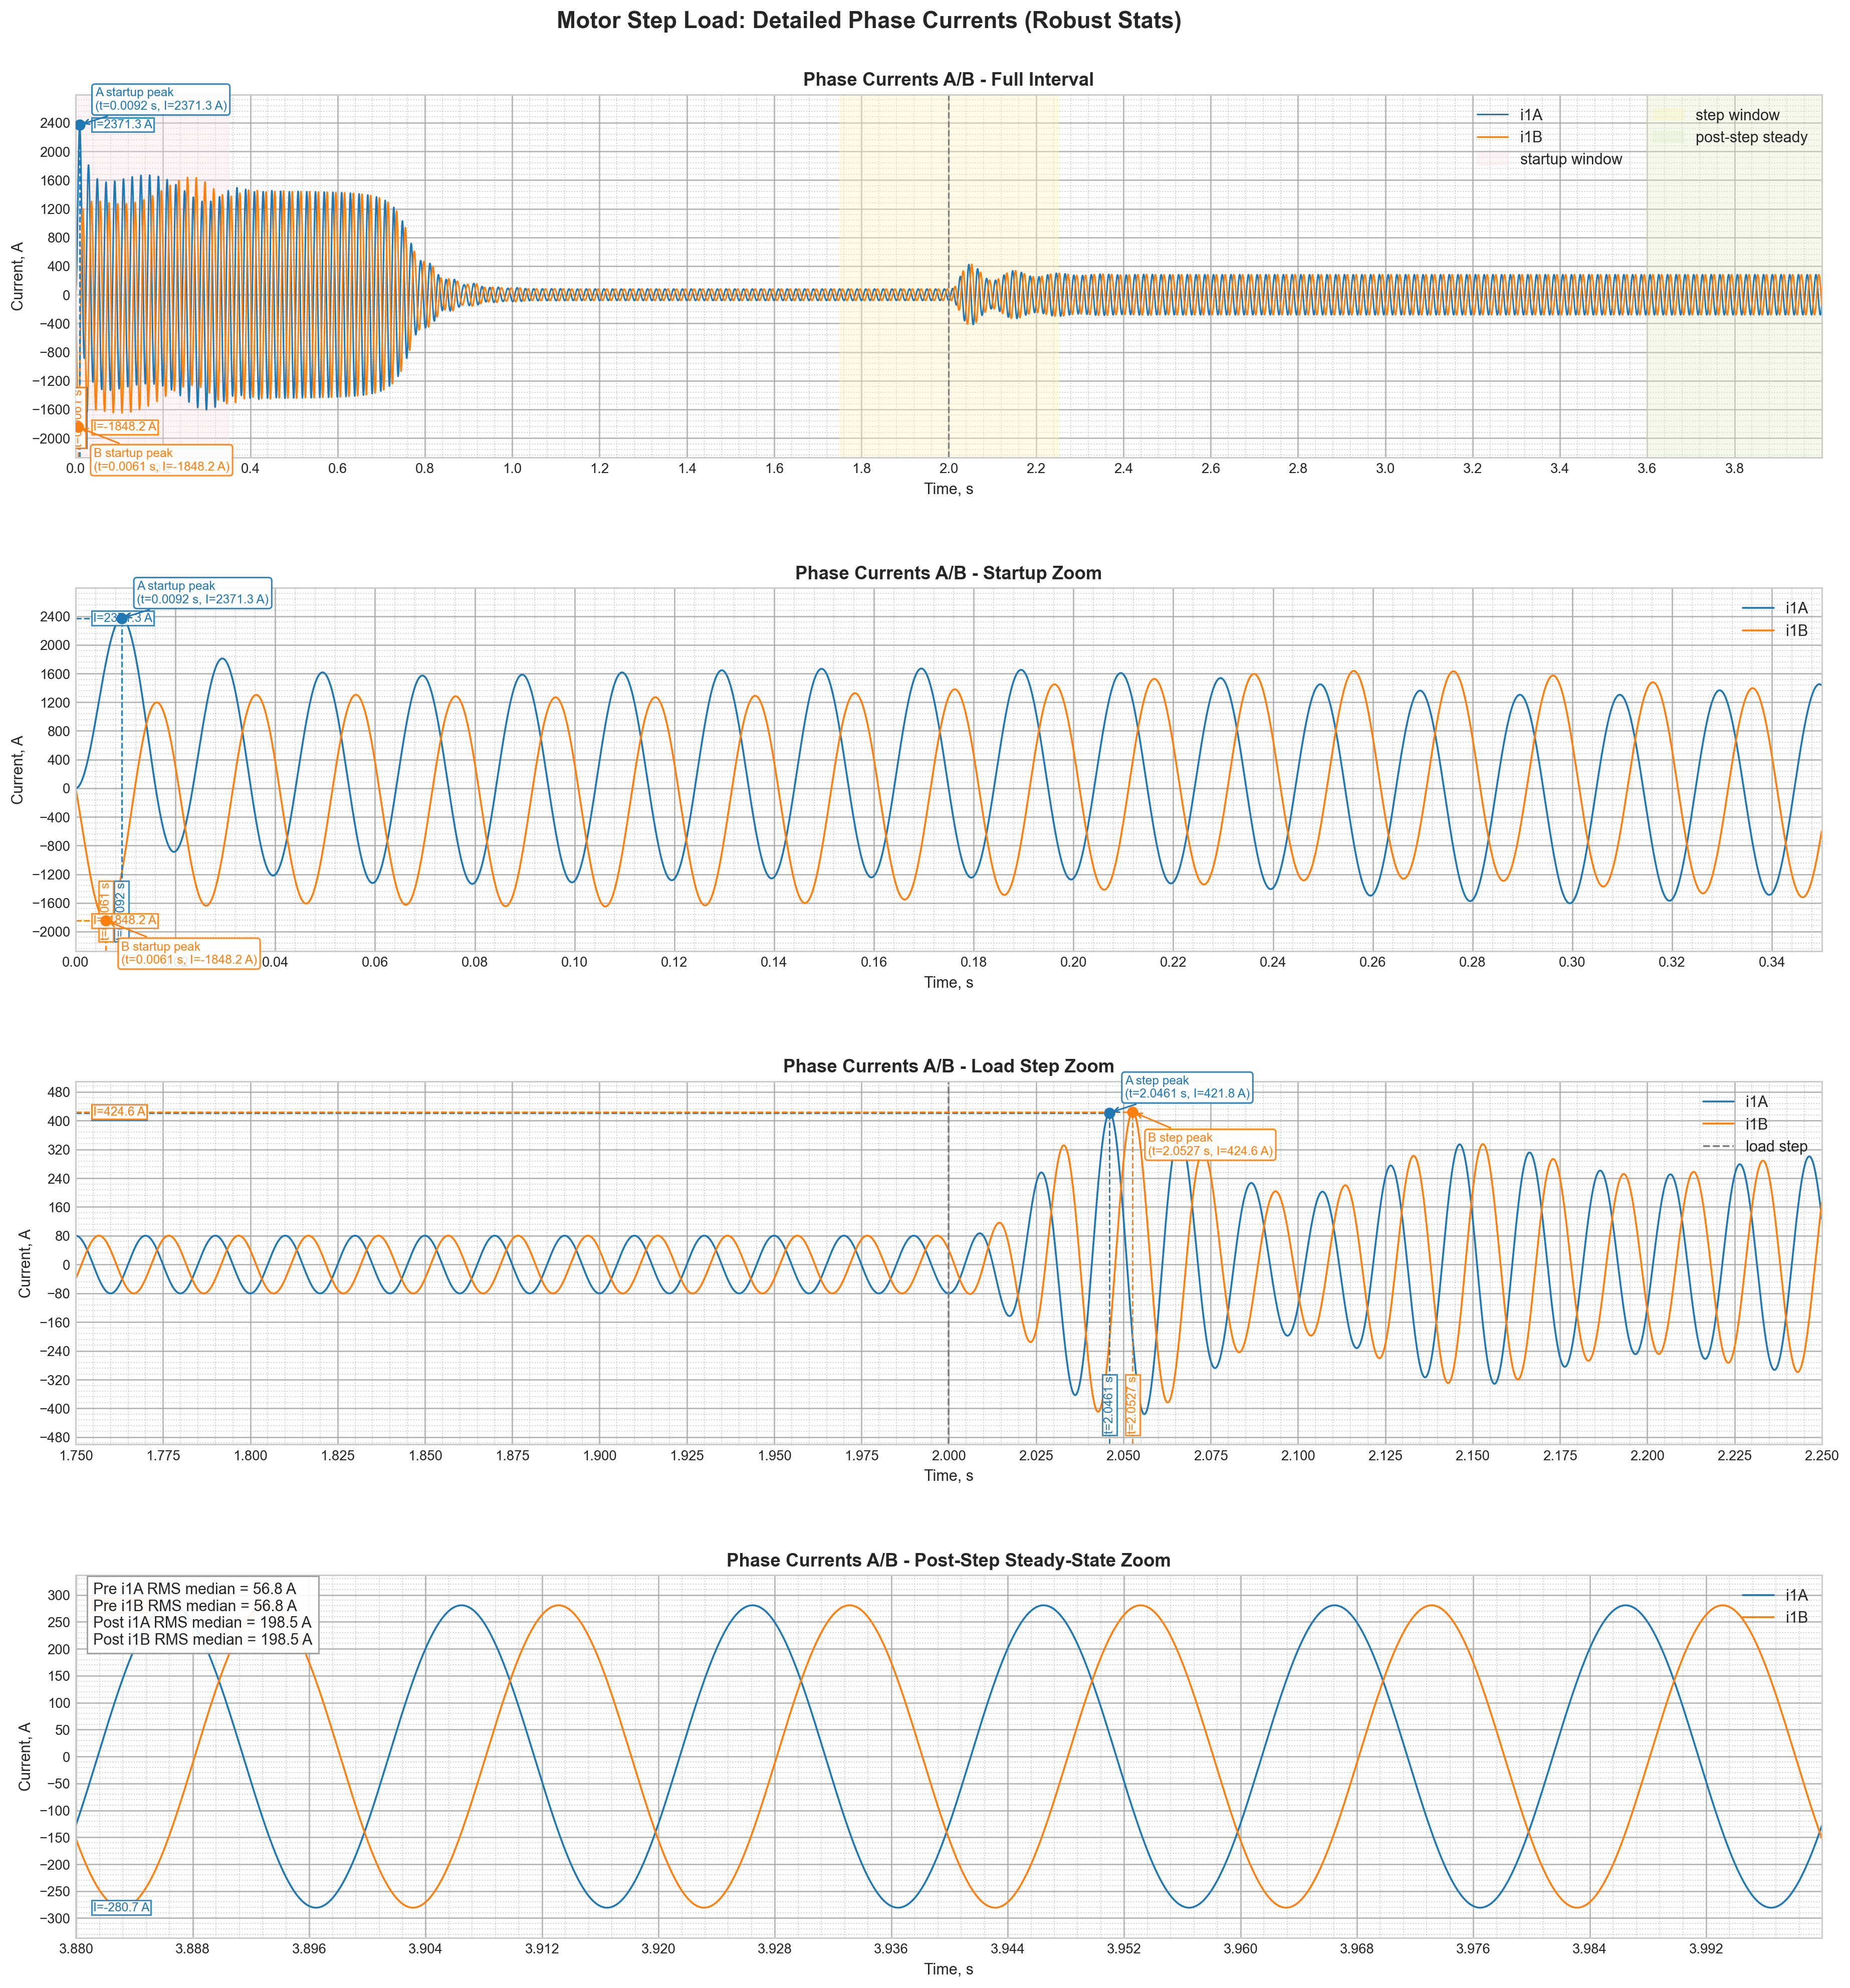

In [56]:
fig, axes = plt.subplots(4, 1, figsize=(18, 19), dpi=220)

# 1) Full time
axes[0].plot(t, iA, color="#1f77b4", linewidth=1.0, label="i1A")
axes[0].plot(t, iB, color="#ff7f0e", linewidth=1.0, label="i1B")
axes[0].axvspan(0.0, startup_end, color="#fde2e4", alpha=0.35, label="startup window")
axes[0].axvspan(t_step - step_half_window, t_step + step_half_window, color="#fff3bf", alpha=0.40, label="step window")
axes[0].axvspan(t[-1] - steady_window, t[-1], color="#e2f0cb", alpha=0.35, label="post-step steady")
axes[0].axvline(t_step, color="#7f7f7f", linestyle="--", linewidth=1.1)
axes[0].set_xlim(t[0], t[-1])
axes[0].set_ylim(*y_limits(np.r_[iA, iB], pad=0.10))
style_axis(axes[0], "Phase Currents A/B - Full Interval", xbins=24, ybins=16, x_minor=5, y_minor=5)
mark_point_with_projection(axes[0], t_peak_A, i_peak_A, "A startup peak", "#1f77b4", (10, 10))
mark_point_with_projection(axes[0], t_peak_B, i_peak_B, "B startup peak", "#ff7f0e", (10, -28))
axes[0].legend(loc="upper right", ncol=2)

# 2) Startup zoom
axes[1].plot(t_start, iA_start, color="#1f77b4", linewidth=1.2, label="i1A")
axes[1].plot(t_start, iB_start, color="#ff7f0e", linewidth=1.2, label="i1B")
axes[1].set_xlim(0.0, startup_end)
axes[1].set_ylim(*y_limits(np.r_[iA_start, iB_start], pad=0.10))
style_axis(axes[1], "Phase Currents A/B - Startup Zoom", xbins=22, ybins=16, x_minor=5, y_minor=5)
mark_point_with_projection(axes[1], t_peak_A, i_peak_A, "A startup peak", "#1f77b4", (10, 10))
mark_point_with_projection(axes[1], t_peak_B, i_peak_B, "B startup peak", "#ff7f0e", (10, -28))
axes[1].legend(loc="upper right")

# 3) Step transient zoom around t = 2.0 s
axes[2].plot(t_step_zoom, iA_step, color="#1f77b4", linewidth=1.2, label="i1A")
axes[2].plot(t_step_zoom, iB_step, color="#ff7f0e", linewidth=1.2, label="i1B")
axes[2].axvline(t_step, color="#7f7f7f", linestyle="--", linewidth=1.2, label="load step")
axes[2].set_xlim(t_step_zoom[0], t_step_zoom[-1])
axes[2].set_ylim(*y_limits(np.r_[iA_step, iB_step], pad=0.10))
style_axis(axes[2], "Phase Currents A/B - Load Step Zoom", xbins=20, ybins=16, x_minor=5, y_minor=5)
mark_point_with_projection(axes[2], t_step_peak_A, i_step_peak_A, "A step peak", "#1f77b4", (10, 10))
mark_point_with_projection(axes[2], t_step_peak_B, i_step_peak_B, "B step peak", "#ff7f0e", (10, -28))
axes[2].legend(loc="upper right")

# 4) Post-step steady-state zoom
axes[3].plot(t_steady_zoom, iA_steady_zoom, color="#1f77b4", linewidth=1.2, label="i1A")
axes[3].plot(t_steady_zoom, iB_steady_zoom, color="#ff7f0e", linewidth=1.2, label="i1B")
axes[3].set_xlim(t_steady_zoom[0], t_steady_zoom[-1])
axes[3].set_ylim(*y_limits(np.r_[iA_steady_zoom, iB_steady_zoom], pad=0.10))
style_axis(axes[3], "Phase Currents A/B - Post-Step Steady-State Zoom", xbins=18, ybins=16, x_minor=5, y_minor=5)
mark_point_with_projection(axes[3], t_post_peak_A, i_post_peak_A, "A post-step peak", "#1f77b4", (10, 10))
mark_point_with_projection(axes[3], t_post_peak_B, i_post_peak_B, "B post-step peak", "#ff7f0e", (10, -28))
axes[3].text(
    0.01,
    0.98,
    (
        f"Pre i1A RMS median = {iA_pre_stats['rms_median']:.1f} A\n"
        f"Pre i1B RMS median = {iB_pre_stats['rms_median']:.1f} A\n"
        f"Post i1A RMS median = {iA_post_stats['rms_median']:.1f} A\n"
        f"Post i1B RMS median = {iB_post_stats['rms_median']:.1f} A"
    ),
    transform=axes[3].transAxes,
    va="top",
    ha="left",
    bbox=dict(facecolor="white", alpha=0.9, edgecolor="#999999"),
)
axes[3].legend(loc="upper right")

fig.suptitle("Motor Step Load: Detailed Phase Currents (Robust Stats)", fontsize=15, weight="bold")
fig.subplots_adjust(left=0.10, right=0.98, top=0.94, bottom=0.06, hspace=0.36)
phase_save_path = output_dir / "02_motor_step_phase_AB_detailed.png"
fig.savefig(phase_save_path, dpi=350)
print(f"Saved: {phase_save_path}")
plt.show()


Saved: C:\Users\Пользователь\PycharmProjects\asynchronousMachine\output\notebooks_currents\02_motor_step_I1_mod_detailed.png


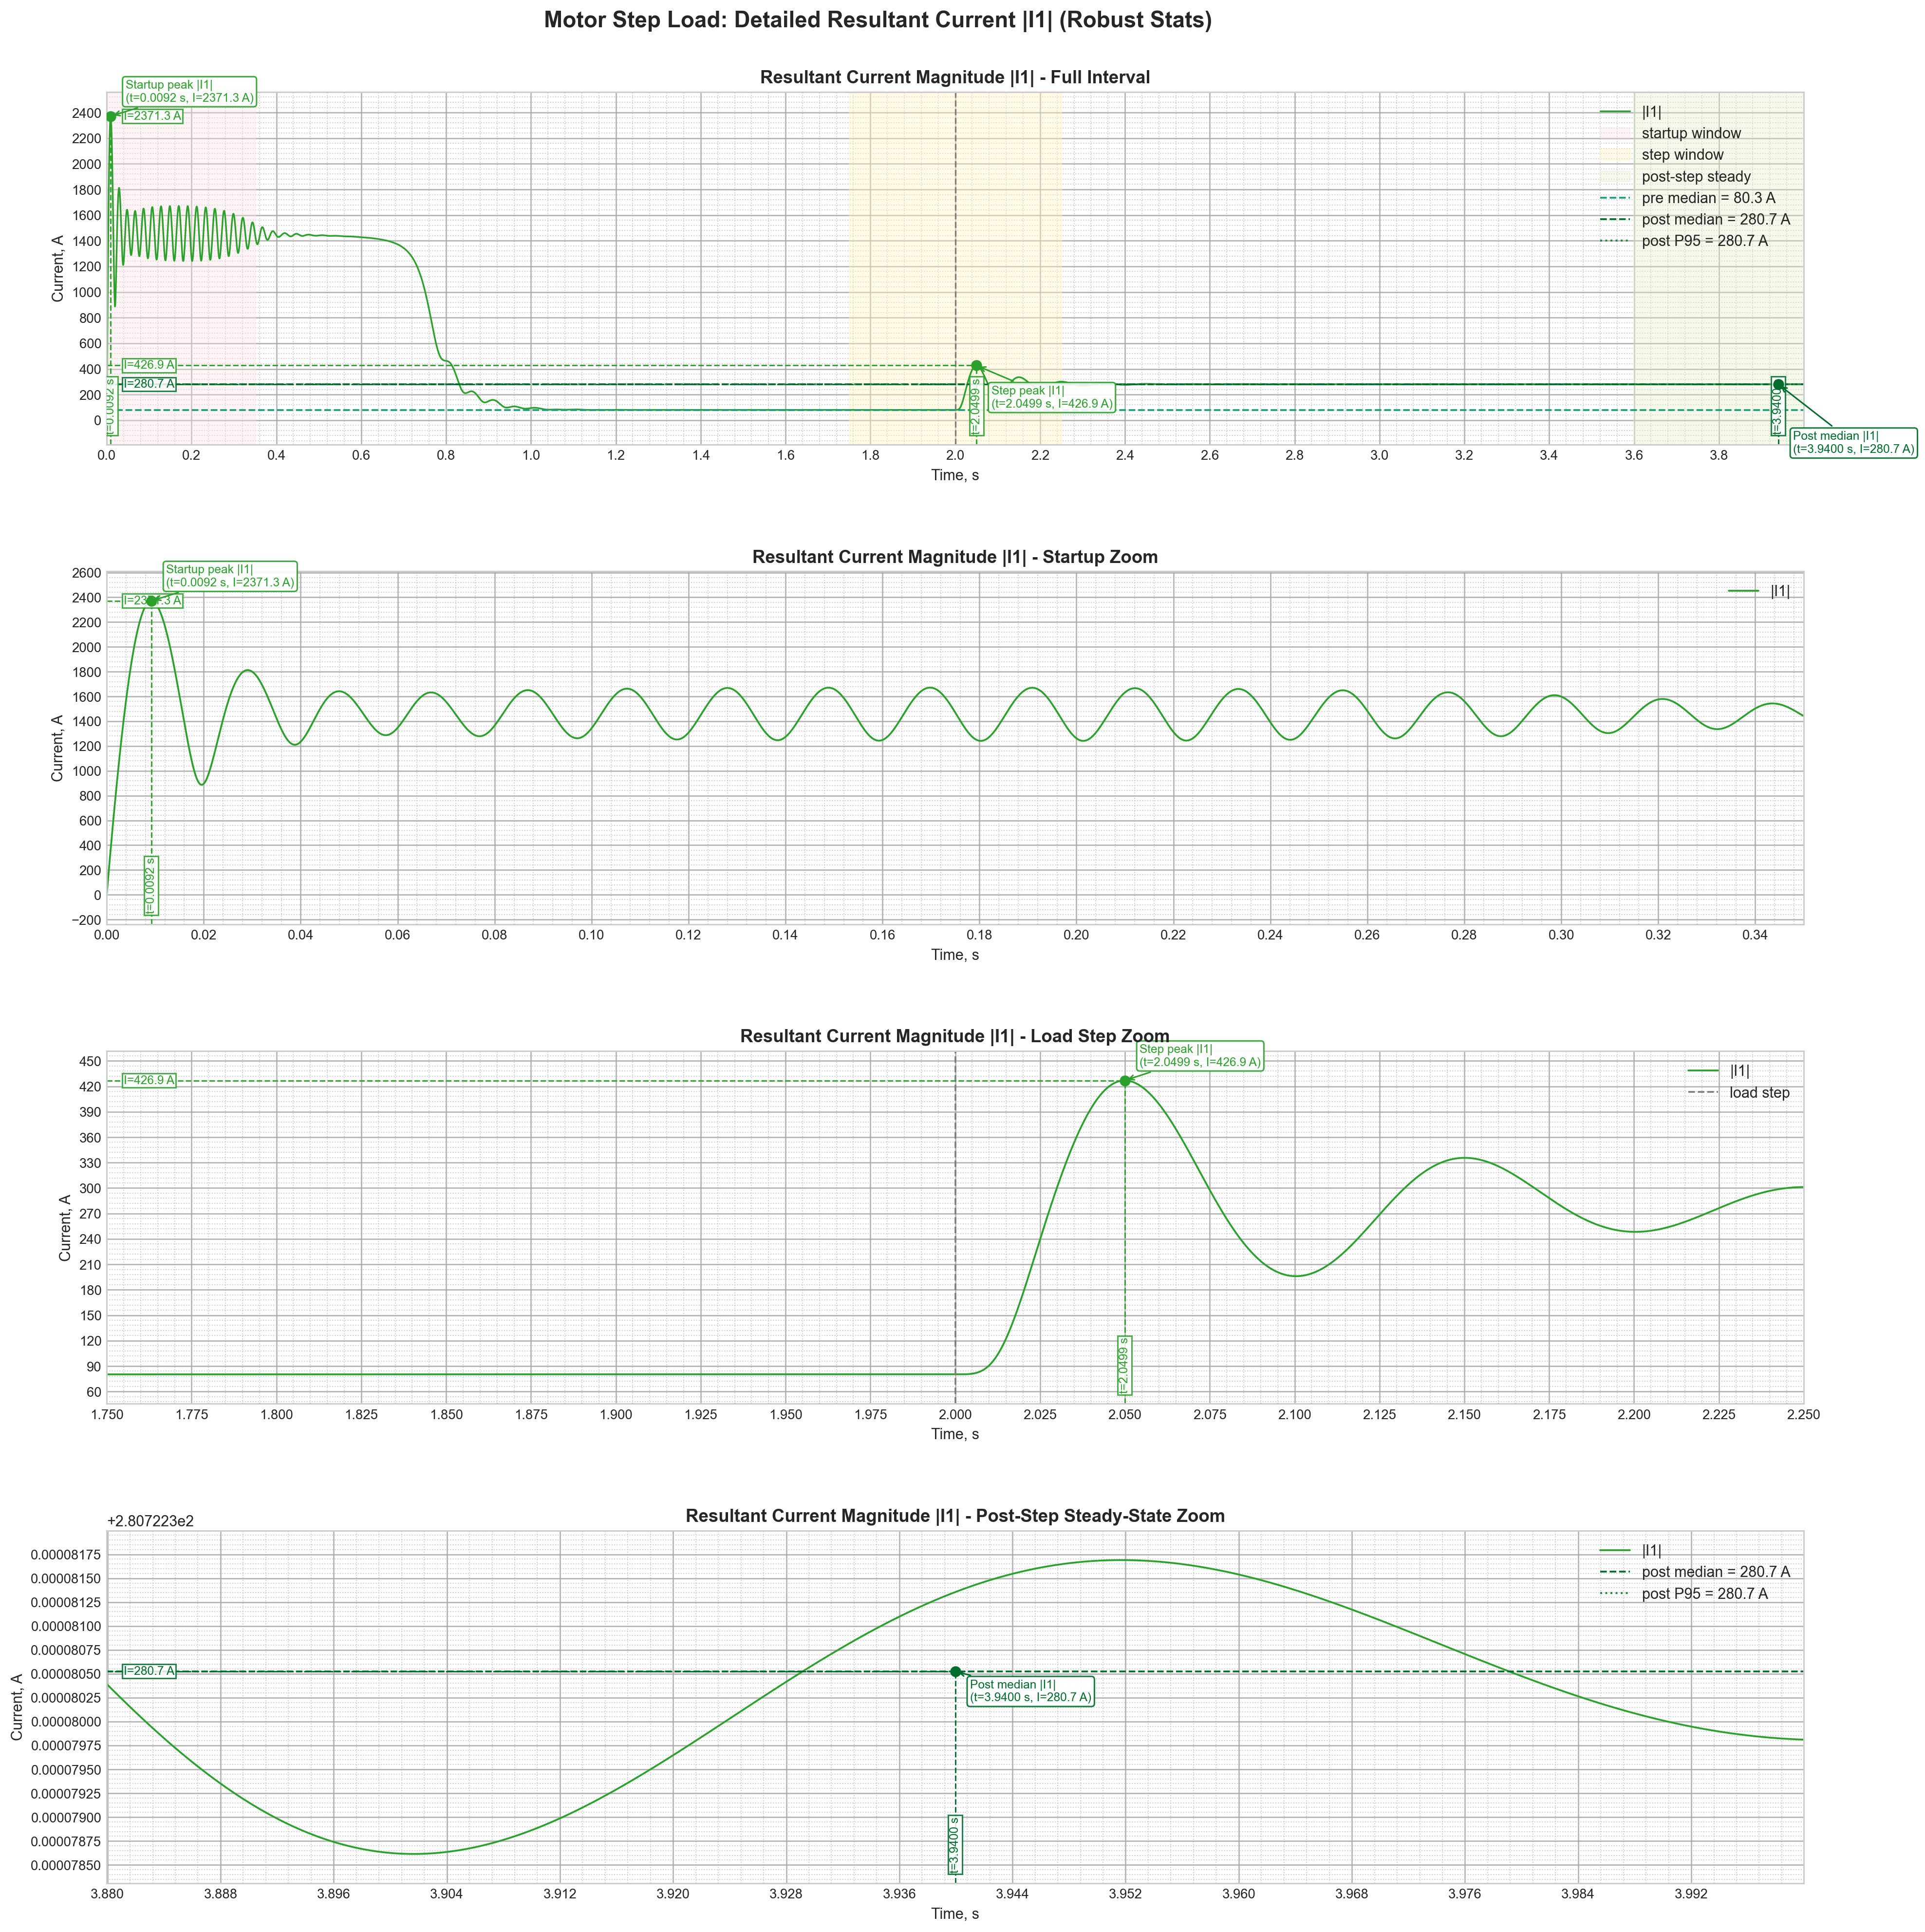

In [57]:
fig, axes = plt.subplots(4, 1, figsize=(18, 19), dpi=220)

# 1) Full time: |I1|
axes[0].plot(t, I1, color="#2ca02c", linewidth=1.1, label="|I1|")
axes[0].axvspan(0.0, startup_end, color="#fde2e4", alpha=0.35, label="startup window")
axes[0].axvspan(t_step - step_half_window, t_step + step_half_window, color="#fff3bf", alpha=0.40, label="step window")
axes[0].axvspan(t[-1] - steady_window, t[-1], color="#e2f0cb", alpha=0.35, label="post-step steady")
axes[0].axvline(t_step, color="#7f7f7f", linestyle="--", linewidth=1.1)
axes[0].axhline(I1_pre_median, color="#1b9e77", linestyle="--", linewidth=1.2, label=f"pre median = {I1_pre_median:.1f} A")
axes[0].axhline(I1_post_median, color="#006d2c", linestyle="--", linewidth=1.2, label=f"post median = {I1_post_median:.1f} A")
axes[0].axhline(I1_post_p95, color="#238b45", linestyle=":", linewidth=1.3, label=f"post P95 = {I1_post_p95:.1f} A")
axes[0].set_xlim(t[0], t[-1])
axes[0].set_ylim(*y_limits(I1, pad=0.08))
style_axis(axes[0], "Resultant Current Magnitude |I1| - Full Interval", xbins=24, ybins=16, x_minor=5, y_minor=5)
mark_point_with_projection(axes[0], t_I1_peak_start, I1_peak_start, "Startup peak |I1|", "#2ca02c", (10, 10))
mark_point_with_projection(axes[0], t_I1_step_peak, I1_step_peak, "Step peak |I1|", "#2ca02c", (10, -28))
mark_point_with_projection(axes[0], I1_post_ref_time, I1_post_median, "Post median |I1|", "#006d2c", (10, -46))
axes[0].legend(loc="upper right")

# 2) Startup zoom: |I1|
axes[1].plot(t_start, I1_start, color="#2ca02c", linewidth=1.2, label="|I1|")
axes[1].set_xlim(0.0, startup_end)
axes[1].set_ylim(*y_limits(I1_start, pad=0.10))
style_axis(axes[1], "Resultant Current Magnitude |I1| - Startup Zoom", xbins=22, ybins=16, x_minor=5, y_minor=5)
mark_point_with_projection(axes[1], t_I1_peak_start, I1_peak_start, "Startup peak |I1|", "#2ca02c", (10, 10))
axes[1].legend(loc="upper right")

# 3) Step transient zoom: |I1|
axes[2].plot(t_step_zoom, I1_step, color="#2ca02c", linewidth=1.2, label="|I1|")
axes[2].axvline(t_step, color="#7f7f7f", linestyle="--", linewidth=1.2, label="load step")
axes[2].set_xlim(t_step_zoom[0], t_step_zoom[-1])
axes[2].set_ylim(*y_limits(I1_step, pad=0.10))
style_axis(axes[2], "Resultant Current Magnitude |I1| - Load Step Zoom", xbins=20, ybins=16, x_minor=5, y_minor=5)
mark_point_with_projection(axes[2], t_I1_step_peak, I1_step_peak, "Step peak |I1|", "#2ca02c", (10, 10))
axes[2].legend(loc="upper right")

# 4) Post-step steady-state zoom: |I1|
axes[3].plot(t_steady_zoom, I1_steady_zoom, color="#2ca02c", linewidth=1.2, label="|I1|")
axes[3].axhline(I1_post_median, color="#006d2c", linestyle="--", linewidth=1.2, label=f"post median = {I1_post_median:.1f} A")
axes[3].axhline(I1_post_p95, color="#238b45", linestyle=":", linewidth=1.3, label=f"post P95 = {I1_post_p95:.1f} A")
axes[3].set_xlim(t_steady_zoom[0], t_steady_zoom[-1])
axes[3].set_ylim(*y_limits(I1_steady_zoom, pad=0.10))
style_axis(axes[3], "Resultant Current Magnitude |I1| - Post-Step Steady-State Zoom", xbins=18, ybins=16, x_minor=5, y_minor=5)
mark_point_with_projection(axes[3], I1_post_ref_time, I1_post_median, "Post median |I1|", "#006d2c", (10, -20))
axes[3].legend(loc="upper right")

fig.suptitle("Motor Step Load: Detailed Resultant Current |I1| (Robust Stats)", fontsize=15, weight="bold")
fig.subplots_adjust(left=0.10, right=0.98, top=0.94, bottom=0.06, hspace=0.36)
mod_save_path = output_dir / "02_motor_step_I1_mod_detailed.png"
fig.savefig(mod_save_path, dpi=350)
print(f"Saved: {mod_save_path}")
plt.show()
